# AAE364 Grand Prix

This notebook is a go-kart race simulation. You are tasked with designing the steering controller.

![GoKart](fig/grandprix_d.jpg)

## Mathematical Model

You control:
* The steering angle of the wheel, $\delta$.

You are given:
* The error across the track direction, $e_x$, from the the reference position which is moving at a fixed velocity and angular rate along the center of the track.
* The reference trajectory's angular velocity, $\omega_r$ and forward velocity, $V$, and side velocity which is always zero.

Your go-kart equations of motion:

$\dot{x} = V\sin(\theta)$

$\dot{y} = V\cos(\theta)$

$\dot{\theta} = \dfrac{V}{l} \tan(\delta)$

The reference trajectory's equations of motion:

$\dot{x_r} = V\sin(\theta_r)$

$\dot{y_r} = V\cos(\theta_r)$

$\dot{\theta_r} = \omega_r$

The equations of motion are non-linear but can be approximated as linear for small angles and constant velocity to yield:

$\ddot{x} = \dfrac{V^2}{l} \delta$


where $x$ is the cross track component measured from the refernce trajectory, $V$ is the velocity, and $l$ is the distance between the vehicle axles. The Lie Group SE2 takes care of the fact that $\theta$ is actually rotating as we go around the track, so you don't have to worry about that. You can assume that y is oriented in the forward direction of the car "along-track", and x is oriented perpindicular, "cross-track".

You are expected to use python or matlab to design a lead-lad or PID compensator. It may help to do some initial sketching by hand of the root locus and Bode plot.

## Control Design Tips

1. **Remember that control feedback should only be used to account for unknown disturbances. If you know how the reference trajectory behaves, you can greatly improve the performance of your controller by utilizing this information.**
1. Sketch the root locus.
1. What type of system do you have?
1. How is the reference trajectory moving? What type of input are you tracking?
1. What steady state error do you expect? What requirements for steady state error do you have?
1. Do you have a settling time requirement? Do you have a maximum overshoot requirement?
1. What is your angle deficiency?
1. Design a PD or lead compensator to handle the angle deficiency.
1. Design a PI or lag compensator to improve the steady state error.
1. Find the transfer function for the noise to the output. Can you design a filter to lessen the noise?
1. Find the transfer function for the disturbance to the output. How does the magnitude of the disturance change as you increase your controller gain?
1. When determing the positon of your dominant closed loop pole pair you must trade-off between your transient requirements and disturance rejection requirements. Increasing gain will decrease your damping ratio, but will typically do a better job of rejecting disturbances.
1. To isolate various effects, it is beneficial to disable the noise and/or disturbance in simulation. You can do this using the following code:

```python
from grandprix import Sim
from grandprix_firstname_lastname import Controller

sim = Sim(Controller, verbose=True)
sim.enable_noise = 0
sim.enable_disturance = 0
sim.run()
sim.plot()
```

## Filtering

Noise is being added to the state used for control feedback. This could represent structural vibrations on your go-kart that are impacting the gyroscope reading used estimating your heading angle. These functions from scipy signals will be helpful for designing filters to diminish the impact of this noise on your control system.

* [elliptical filter design](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ellip.html#scipy.signal.ellip)
* [butterworth filter design](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter)


This command asks scipy to design a 2nd order elliptical low pass filter with a pass band ripple of $6$ dB, and stop band attenuation of 20 dB, with the cut-off frequency starting at 3 Hz. We then pass the generated numerator and denominator to the python control library to build our transfer function.

```python
H_ellip = control.tf(*scipy.signal.ellip(
    2, 6, 20, 3*2*np.pi, btype='lowpass', analog=True))
```

## Extra Credit

Each submitted controller will be scored using the distance travelled using the simulator during a fixed amount of time. The max speed is set at 1 m/s, the length of the track is 5 m, and the time is set to 5 seconds, therefore, the most you can achieve is about one lap in the time allotted, or about 5 m, unless you get clever.

You will receive extra credit by the following table:

1. Top  25 \% of the class: 4 points extra credit
1. Top  50 \% of the class: 3 points extra credit
1. Top  75 \% of the class: 2 points extra credit
1. Top 100 \% of the class: 1 points extra credit

Any exact ties will be scored by an average of the tied participants positions. For instance, if you work as a team and you place 20-24 in the class, you will be scored for extra credit as if you all were 22nd in the class.

## Setup

* If you don't have python on your computer and wish to install it, I recommend using [Anaconda](www.anaconda.com).
* You may also run python remotely using [Google Colab](https://colab.research.google.com).

To get started, you will need to install the control library and any other missing libraries.

```bash
pip install control
```

Or, if you prefer conda:

```bash
conda install control
```

Next, you will need to download these scripts:

* [grandprix.py](./grandprix.py): This contains the simulators and control code you will need. To use it, see the example below.
* [grandprix_template.py](./grandprix_template.py): Modify this and rename it: grandprix_your_name.py, where your is your first name, and name is your last name as used on blackboard. To run the simultion simply import Controller from your script as shown in the example below.

## Submission

To submit your script for grading, upload your Controller in a standalone file named 'grandprix_firstname_lastname.py' to blackboard make sure it follows the format below. Only change the sections that say " WRITE YOUR... HERE". I will download all of the uploaded scripts and then use your name from the script to automatically grade your, so make sure you follow the format given exactly. You may work as individuals or teams. If you work as a team, upload the script with the name above for each team member.

In [1]:
# uncomment the line below to install the control library
#!pip install control

In [2]:
%%file grandprix_template.py
from grandprix import DiscreteStateSpace
import numpy as np
import control
import scipy

class Controller:
  """
  You must design a controller using a PID or lead-lag controller or
  a set or any combination of these controller to design the best
  control system possible that drives the race course without
  leaving the track.
  """
  
  def __init__(self, dt):
    """
    @param dt: the update rate of the controller
    """
    self.dt = dt

    ###
    ### WRITE YOUR OWN CONTROLLERS HERE
    ###
    s = control.tf([1, 0], [0, 1])
    
    H = 1 + 1/s + 1*20/(s+20)
    self.ex_steering = DiscreteStateSpace(H, dt)

    # don't change this
    self.desired_speed = 1
  
  def update(self, error, u_ref):
    """omega_ref
    current state:
    @param error: [etheta, ex, ey]
    @param u_ref: [, x_ref, velocity_ref]
    
    ouput
    @param throttle: the throttle to the motor, commands velocity m/s
    @param steering: the steering angle of the vehicle in radians
    """
    etheta, ex, ey = error
    omega_ref, x_ref, velocity_ref = u_ref
    
    ###
    ### WRITE YOUR CODE HERE TO CONTROL THE CAR
    ###
    steering = float(self.ex_steering.update(ex))

    # for the race, just leave the throttle at desired_speed
    throttle = self.desired_speed
    return throttle, steering

Overwriting grandprix_template.py


# Example Controller

We will now test the peformance of the template controller. If you follow the design tips above, you should be able to do better. If you go off the track, your vehicle will slow down to half speed.

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

sim started
sim complete
Distance:     0.8120 m


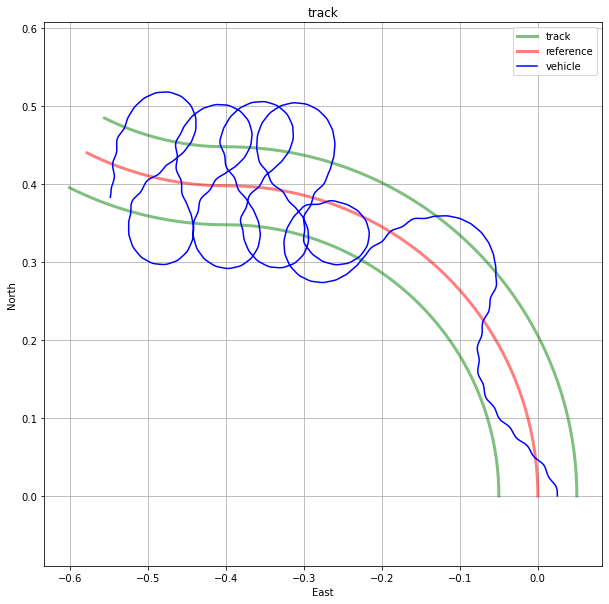

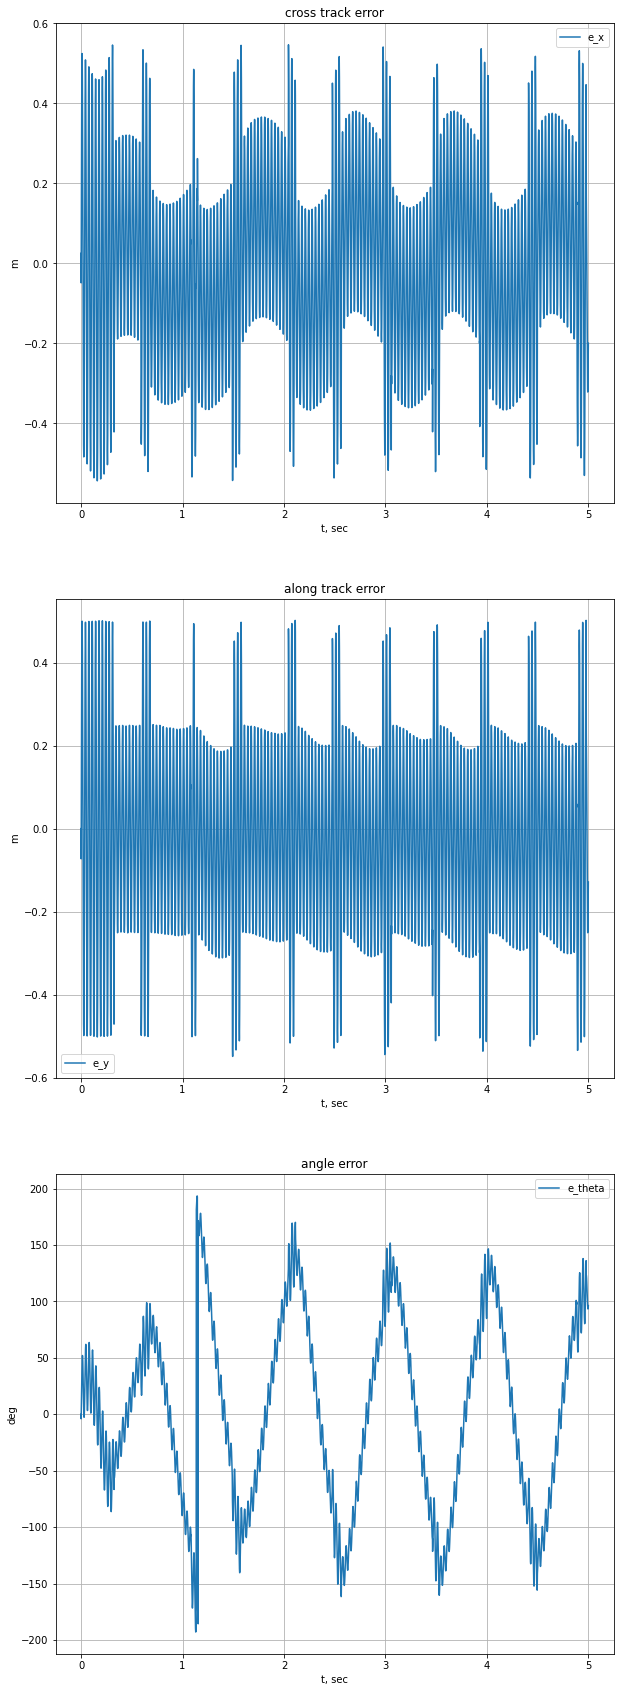

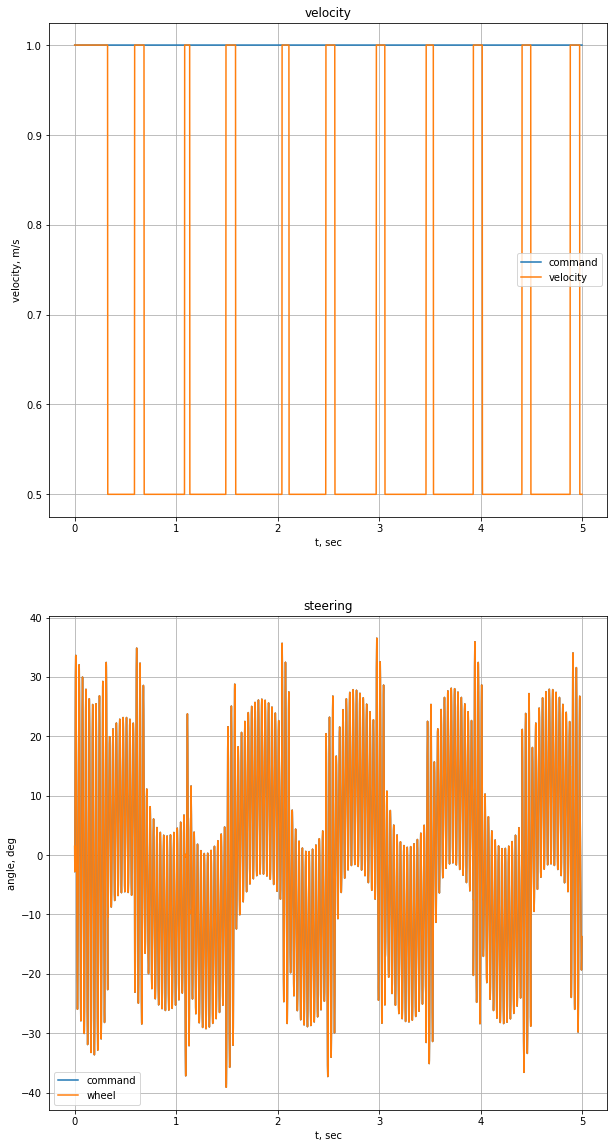

In [4]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '../prob/grandprix')
from grandprix import Sim, DiscreteStateSpace
from grandprix_template import Controller
#from grandprix_example import Controller

# set this random seed to match results from races in class
# comment this line to get random races each time
np.random.seed(2234)
sim = Sim(Controller)

# you can modify various properties of the simulation here,
# When grading, I will test with the default settings.
#sim.tf = 5
sim.verbose = True

# uncommment this to try going straight with no disturbance first
#sim.enable_disturbance = 0
#sim.enable_noise = 0
# sim.track = [0]

sim.run()
sim.plot()